---
title: STATS/CSE 780 - Project
author: "Xiaoran Xie (Student number: 400549859)"
date: "2023/11/27"
format: pdf
execute: 
  echo: true
  message: false
  warning: false
bibliography: STATS780.bib
fontsize: 11pt
geometry: 
  - margin = 1in
linestretch: 1.5
---

## Introduction

Stroke, as an epidemic that kills millions of people every year, has become a health issue that we need to be concerned about. If the risk of stroke can be predicted based on an individual’s health information, it will reduce the prevalence of the disease in non-patients, as well as help patients to receive timely treatment and reduce mortality. Therefore, the main goal of the project is to find the factors most associated with stroke risk and to build a prediction model based on this information. This will help doctors more accurately assess a patient’s stroke risk and give timely medical advice. This dataset[@data] contains health information on 5110 patients with confirmed or undiagnosed stroke obtained from the Kaggle platform, which is detailed and helps to find potential risk factors.

## Results

The SVM model has a higher overall accuracy and AUC compared to the decision tree model, suggesting it is generally better at distinguishing between the two classes. However, the SVM model, despite its higher accuracy, fails completely to identify any stroke cases, which is a critical flaw in a medical diagnosis context. And the decision tree model struggles with a large number of false positives and misses a substantial number of stroke cases. In the real world, the recall for class 1 (stroke) is particularly important to minimize the risk of missing actual stroke patients. Therefore, despite the higher accuracy and AUC of the SVM model, neither model is satisfactory for predicting stroke cases. 

Further model tuning, feature selection, or alternative modeling approaches may be necessary to improve performance, especially for class 1 prediction. Also, the imbalance of the dataset is also an issue we should focus on since that class 1 (stroke) has much fewer instances compared to class 0 (non-stroke), which could be affecting the model's ability to learn from the minority class.

\newpage
## Attribute Information
| Feature           | Description                                                  |
|-------------------|--------------------------------------------------------------|
| id                | unique identifier                                            |
| gender            | "Male", "Female" or "Other"                                  |
| age               | age of the patient                                           |
| hypertension      | 0 if the patient doesn't have hypertension, 1 if they do     |
| heart_disease     | 0 if the patient doesn't have any heart diseases, 1 if they do |
| ever_married      | "No" or "Yes"                                                |
| work_type         | "children", "Govt_job", "Never_worked", "Private" or "Self-employed" |
| Residence_type    | "Rural" or "Urban"                                           |
| avg_glucose_level | average glucose level in blood                               |
| bmi               | body mass index                                              |
| smoking_status    | "formerly smoked", "never smoked", "smokes" or "Unknown"     |
| stroke            | 1 if the patient had a stroke or 0 if not                    |
## Data Preprocessing

In [8]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from graphviz import Source
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from collections import Counter

In [9]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.drop(columns=['id'], inplace=True)
print(df.shape)
print(df.describe())
df.head()

(5110, 11)
               age  hypertension  heart_disease  avg_glucose_level  \
count  5110.000000   5110.000000    5110.000000        5110.000000   
mean     43.226614      0.097456       0.054012         106.147677   
std      22.612647      0.296607       0.226063          45.283560   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.245000   
50%      45.000000      0.000000       0.000000          91.885000   
75%      61.000000      0.000000       0.000000         114.090000   
max      82.000000      1.000000       1.000000         271.740000   

               bmi       stroke  
count  4909.000000  5110.000000  
mean     28.893237     0.048728  
std       7.854067     0.215320  
min      10.300000     0.000000  
25%      23.500000     0.000000  
50%      28.100000     0.000000  
75%      33.100000     0.000000  
max      97.600000     1.000000  


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Handle Missing Value

In [10]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [11]:
df.dropna(how='any', inplace=True)

### Encode Categorical Data

In [12]:
numeric_columns = ['age', 'bmi', 'avg_glucose_level']
categorical_columns = ['gender', 'hypertension', 'heart_disease',
                       'ever_married', 'work_type', 'Residence_type',
                       'smoking_status', 'stroke']
# use dictionary to save column name as key, save categories as value
object_categorical_columns_dict = {} 
for col in df.columns:
    if df[col].dtype == 'object':
        object_categorical_columns_dict[col] = df[col].value_counts().index.to_list()          
print(object_categorical_columns_dict)

{'gender': ['Female', 'Male', 'Other'], 'ever_married': ['Yes', 'No'], 'work_type': ['Private', 'Self-employed', 'children', 'Govt_job', 'Never_worked'], 'Residence_type': ['Urban', 'Rural'], 'smoking_status': ['never smoked', 'Unknown', 'formerly smoked', 'smokes']}


#### Method 1: One-hot Encoding
Firstly, 我尝试了来源于作者[@data2]的方法，使用one-hot编码将字符串类型的数据转化为了整数。
One-hot encoding creates a separate column for each category, capturing the magnitude of relationships but not the ordinal relationships

In [13]:
# one hot encoding for multiple categories
df = pd.get_dummies(df, columns=object_categorical_columns_dict.keys(), drop_first=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4909 entries, 0 to 5109
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             4909 non-null   float64
 1   hypertension                    4909 non-null   int64  
 2   heart_disease                   4909 non-null   int64  
 3   avg_glucose_level               4909 non-null   float64
 4   bmi                             4909 non-null   float64
 5   stroke                          4909 non-null   int64  
 6   gender_Male                     4909 non-null   uint8  
 7   gender_Other                    4909 non-null   uint8  
 8   ever_married_Yes                4909 non-null   uint8  
 9   work_type_Never_worked          4909 non-null   uint8  
 10  work_type_Private               4909 non-null   uint8  
 11  work_type_Self-employed         4909 non-null   uint8  
 12  work_type_children              49

#### Method 2: Label Encoding
Label encoding assigns a unique integer to each category, preserving the ordinal relationships between categories but not the magnitude of those relationships

In [ ]:
encoded_values = {}
temp_dict = {}
print('_'*45)
for col, values in object_categorical_columns_dict.items():
    print(f'column: {col}')
    for index, val in enumerate(values):
        temp_dict[val] = index
        print(f'{val}: {index}')
    encoded_values[col] = temp_dict
    df[col] = df[col].replace(temp_dict)
    print('_'*45)

In [ ]:
df.info()

label encoding is best if there is an ordinal relationship between categories, one-hot encoding is best if there is no ordinal relationship between categories
因为我们的数据类别和顺序没有关系，所以我们采用one-hot encoding作为更合适的编码方式

### Explore and Visualise Data
stroke: 1 if the patient had a stroke or 0 if not[@data]

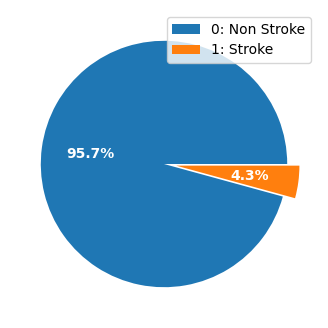

In [14]:
x = df['stroke'].value_counts()
explode = [0, 0.1]
fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(aspect="equal"))
plt.pie(x, explode=explode, autopct='%1.1f%%',
        textprops=dict(color="w", weight='bold', size=10))
plt.legend(labels = ['0: Non Stroke', '1: Stroke'])
plt.show()

#### Numeric Columns: Age, bmi, avg_glucose_level

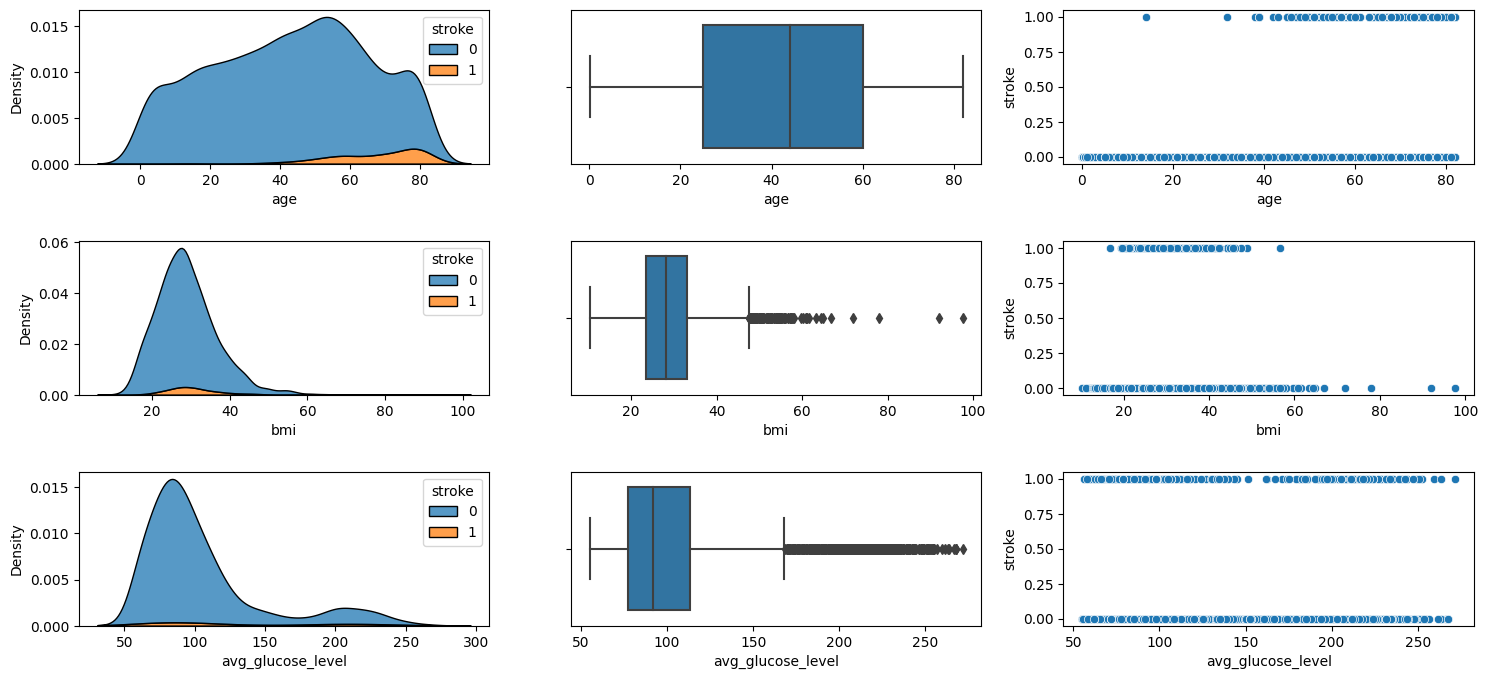

In [15]:
i = 0
fig, ax = plt.subplots(3, 3, figsize=(18, 8))
plt.subplots_adjust(hspace = 0.5)
for num_col in numeric_columns :
    sns.kdeplot(x=num_col, hue='stroke', data=df, multiple='stack', ax=ax[i,0])
    sns.boxplot(x=num_col, data=df, ax=ax[i, 1])
    sns.scatterplot(x=num_col, y='stroke', data=df, ax=ax[i, 2])
    i+=1
plt.show()

Those who have had a stroke are in: age in range 40 to 85, bmi in range 20 to 40, glocuse level in range 50 to 130

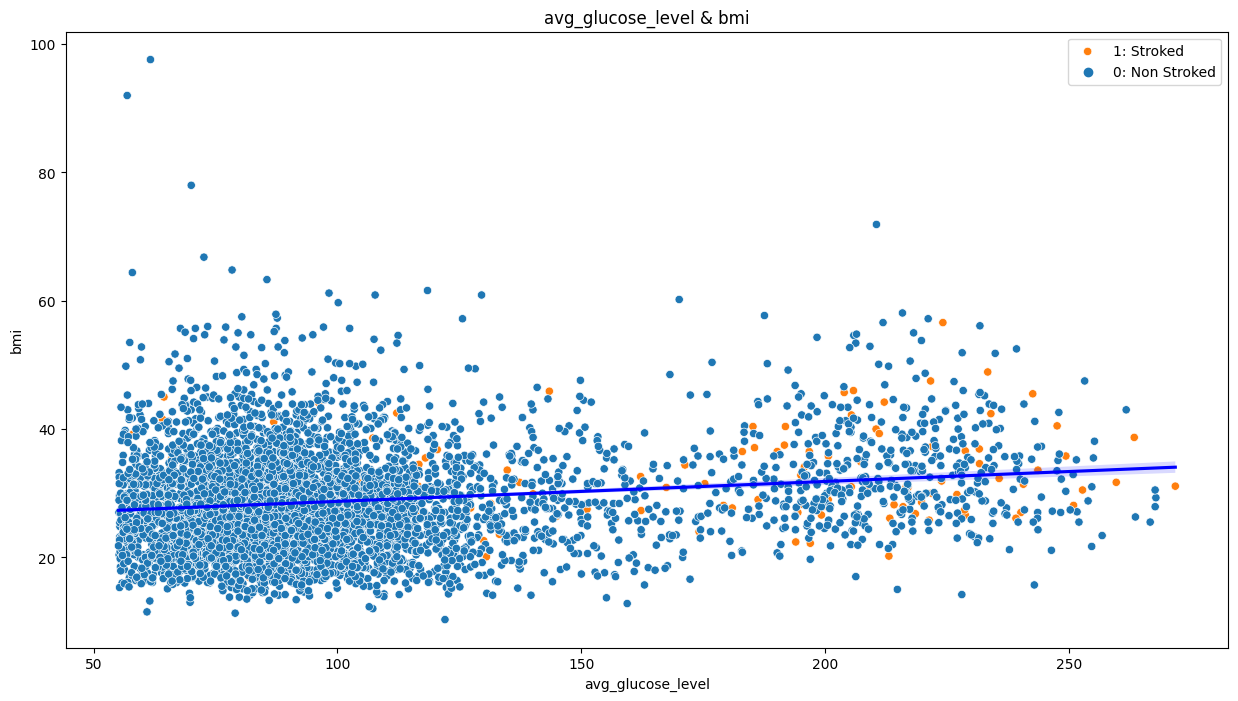

In [16]:
plt.figure(figsize = (15,8))
sns.scatterplot(data=df, x='avg_glucose_level',y='bmi',hue='stroke')
sns.regplot(data=df, x='avg_glucose_level', y='bmi', 
            scatter=False, ci=95, line_kws={"color": "blue"})
plt.xlabel('avg_glucose_level')
plt.ylabel('bmi')
plt.title('avg_glucose_level & bmi')
plt.legend(labels=['1: Stroked', '0: Non Stroked'])
plt.show()

There appears to be a slight positive correlation between average blood glucose levels and BMI. The figure also shows that most non-stroke patients have a BMI below 60 and an average blood glucose level below 130.修改一下

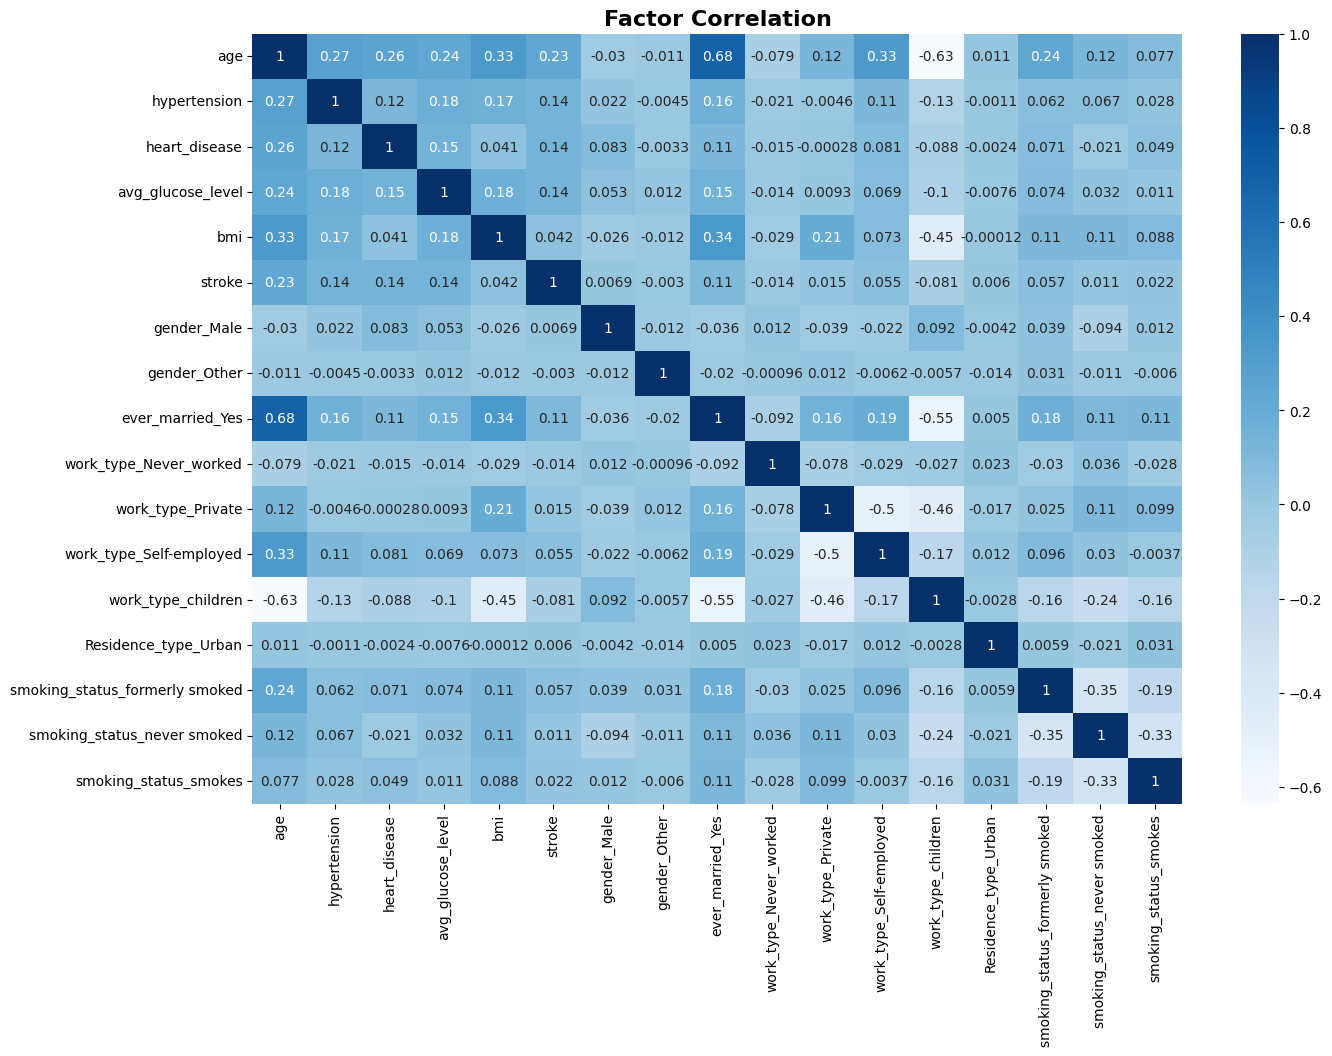

In [17]:
# Correlation between each factor
corr = df.corr()
plt.figure(figsize = (15,10))
sns.heatmap(corr, cmap = 'Blues', annot = True)
plt.title("Factor Correlation", fontweight = "bold", fontsize=16)
plt.savefig(f'Factor_Correlation.png')
plt.show()

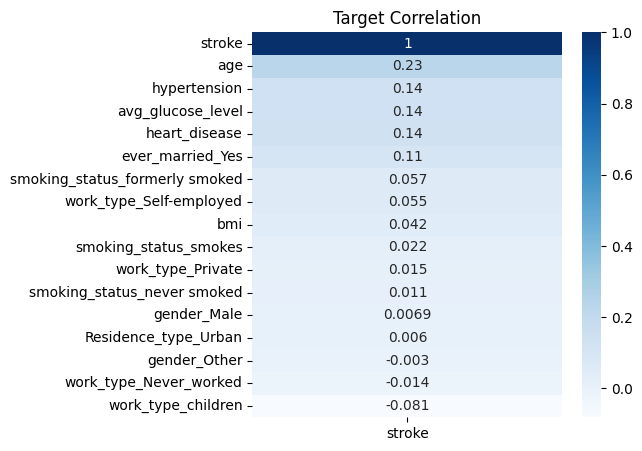

In [18]:
# Correlation for the target variable (stroke)
plt.figure(figsize = (5,5))
sns.heatmap(df.corr()[['stroke']].sort_values(by='stroke', ascending=False), annot = True, cmap = 'Blues')
plt.title('Target Correlation')
plt.savefig(f'Target_Correlation.png')
plt.show()

## Feature Scaling and Upscaling
### Data Splitting
split the data into training set and testing set

In [19]:
X = df.drop(columns='stroke')
y = df['stroke']
X.columns
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

### Handle Data Imbalance

In [20]:
sm = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
print(f'Original class distribution: {Counter(y_train)}')
print(f'Oversampled class distribution: {Counter(y_train_oversampled)}')
X_train = X_train_oversampled
y_train = y_train_oversampled

Original class distribution: Counter({0: 3535, 1: 146})
Oversampled class distribution: Counter({0: 3535, 1: 3535})


### Normalization

In [21]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_train.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
count,7070.000000,7070.000000,7070.000000,7070.000000,7070.000000,7070.000000,7070.000000,7070.000000,7070.000000,7070.000000,7070.000000,7070.000000,7070.000000,7070.000000,7070.000000,7070.000000
mean,0.668740,0.090806,0.043706,0.300291,0.224588,0.326591,0.000141,0.735361,0.002687,0.487129,0.112306,0.070863,0.393918,0.124187,0.293635,0.093777
std,0.268896,0.287354,0.204454,0.262498,0.081996,0.468999,0.011893,0.441172,0.051774,0.499870,0.315764,0.256614,0.488652,0.329818,0.455459,0.291538
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.508041,0.000000,0.000000,0.106251,0.173482,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.718086,0.000000,0.000000,0.194162,0.215613,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.902055,0.000000,0.000000,0.448043,0.267329,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Data Visualization Functions

In [22]:
def cm(y_test, y_predict, modelName):
    cm = confusion_matrix(y_test, y_predict)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix for {modelName}')
    plt.savefig(f'{modelName}_cm.png')
    
def roc(y_test, y_pred_probs, modelName):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC for {modelName}')
    plt.legend(loc="lower right")
    plt.savefig(f'{modelName}_roc.png')
    plt.show()

## Model Selection
### Model 1: Logistic Regression
#### Standardization and Cross Validation 
use L1(Lasso regression) as shrinkage method for feature selection to reduce the complexity of the model, use cross validation by grid search to find optimal parameter C for Logistic Regression model

In [28]:
# create logistic regression model with L1 
cv_lr = LogisticRegression(penalty='l1', solver='liblinear')
# set paremeter grid, create cross validation by grid search
param_gs = {
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight': ['balanced'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}
cv_gs_lr = GridSearchCV(cv_lr, param_gs, cv=5, scoring='accuracy')
cv_gs_lr.fit(X_train, y_train)
print("Optimal tuning parameters: ", cv_gs_lr.best_params_)
print("Optimal cross-validation score: ", cv_gs_lr.best_score_)

Optimal tuning parameters:  {'C': 1, 'class_weight': 'balanced', 'solver': 'saga'}
Optimal cross-validation score:  0.8585572842998586


### Training and Prediction

In [29]:
optimal_C = cv_gs_lr.best_params_['C']
class_weight = cv_gs_lr.best_params_['class_weight']
solver = cv_gs_lr.best_params_['solver']
lr = LogisticRegression(penalty='l1', C=optimal_C,
                        class_weight=class_weight, solver=solver)
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
lr_score = round(lr.score(X_test, y_test), 5)
report = classification_report(y_test, y_predict)
print(f'Accuracy: {lr_score}')
print(report)

Accuracy: 0.83713
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1165
           1       0.14      0.41      0.21        63

    accuracy                           0.84      1228
   macro avg       0.55      0.64      0.56      1228
weighted avg       0.92      0.84      0.87      1228



### Confusion Matrix

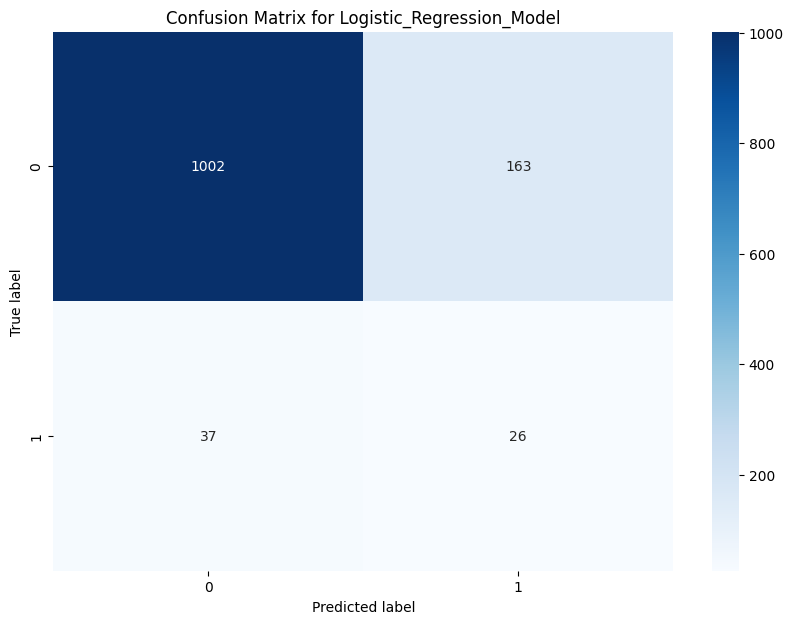

In [31]:
modelName = 'Logistic_Regression_Model'
cm(y_test, y_predict, modelName)

### Model 2: Decision Tree
#### Cross Validation 

In [278]:
# set paremeter grid, create cross validation by grid search
param_gs = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': list(np.arange(4, 30, 1))
}
cv_dt = DecisionTreeClassifier()
cv_gs_dt = GridSearchCV(estimator=cv_dt, cv=10, param_grid=param_gs)
cv_gs_dt.fit(X_train, y_train)
print("Optimal tuning parameters: ", cv_gs_dt.best_params_)
print("Optimal cross-validation score: ", cv_gs_dt.best_score_)

Optimal tuning parameters:  {'criterion': 'log_loss', 'max_depth': 20, 'splitter': 'best'}
Optimal cross-validation score:  0.9405940594059405


#### Training and Prediction

In [279]:
criterion = cv_gs_dt.best_params_['criterion']
max_depth = cv_gs_dt.best_params_['max_depth']
splitter = cv_gs_dt.best_params_['splitter']
dt = DecisionTreeClassifier(
    criterion=criterion, max_depth=max_depth, splitter=splitter)
dt.fit(X_train, y_train)
dt_score = round(dt.score(X_test, y_test), 5)
y_predict = dt.predict(X_test)
report = classification_report(y_test, y_predict)
print(f'Accuracy: {dt_score}')
print(report)

Accuracy: 0.87541
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      1165
           1       0.14      0.27      0.18        63

    accuracy                           0.88      1228
   macro avg       0.55      0.59      0.56      1228
weighted avg       0.92      0.88      0.89      1228



#### Confusion Matrix

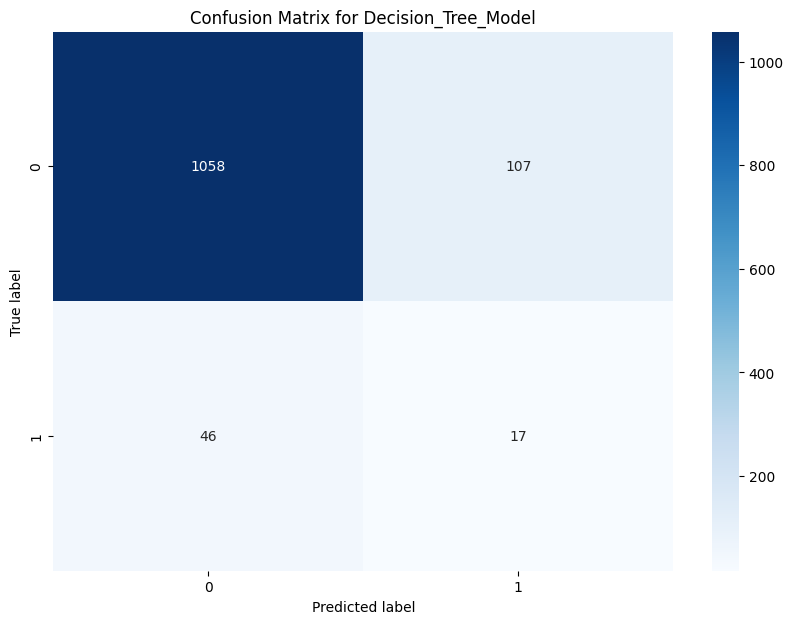

In [280]:
modelName = 'Decision_Tree_Model'
cm(y_test, y_predict, modelName)

#### ROC

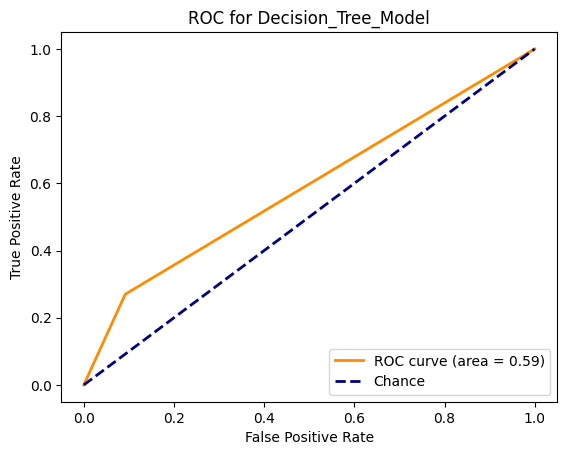

In [281]:
y_pred_prob = dt.predict_proba(X_test)[:, 1]
roc(y_test, y_pred_prob, modelName)

#### Decision Tree Graph

In [282]:
dot_data = export_graphviz(dt_fit, out_file=None, feature_names=X.columns,
                           class_names=['0: Non Stroke', '1: Stroke'], filled=True,
                           rounded=True, special_characters=True)
# Generate a graph from the Dot file and display it
graph = Source(dot_data)
graph.render(f"{modelName}_graph", format='png', cleanup=True)

'Decision_Tree_Model Graph.png'

决策树的可视化中出现"Stroke"而没有"Non Stroke"可能是由于在生成决策树时使用的数据不平衡或者分类标准导致大多数的叶节点被划分为"Stroke"。这可能反映了模型过于偏向于预测中风，也可能是因为训练数据中中风的样本比例较高，或者模型在分割节点时对于中风的预测更加敏感。
如果你的数据集中中风和未中风的样本数量差异很大，决策树可能会倾向于分类多数类，因为这样可以最大化节点的信息增益或纯度，从而导致大多数的叶节点表示多数类。这是不平衡数据集在训练机器学习模型时常见的问题。

### Model 3: Random Forest
#### Cross Validation 

In [ ]:
# set paremeter grid, create cross validation by grid search
param_gs = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [3,5, None],
    'n_estimators': [50, 100]
}
cv_dt = DecisionTreeClassifier()
cv_gs_dt = GridSearchCV(estimator=cv_dt, cv=10, param_grid=param_gs)
cv_gs_dt.fit(X_train, y_train)
print("Optimal tuning parameters: ", cv_gs_dt.best_params_)
print("Optimal cross-validation score: ", cv_gs_dt.best_score_)

### Model 4: Support Vector Machine
首先在原始数据上训练模型，然后在降维后的数据上进行可视化。这种方法保证了模型的准确性，同时也允许了可视化分析。
#### Cross Validation 

In [23]:
# set paremeter grid, create cross validation by grid search
param_gs = {
    'C' : [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
    'gamma' : [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
}
cv_svc = SVC()
cv_gs_svc = GridSearchCV(estimator=cv_svc, param_grid=param_gs, cv=5)
cv_gs_svc.fit(X_train, y_train)
print("Optimal tuning parameters: ", cv_gs_svc.best_params_)
print("Optimal cross-validation score: ", cv_gs_svc.best_score_)

Optimal tuning parameters:  {'C': 10, 'gamma': 1000}
Optimal cross-validation score:  0.9613861386138615


#### Training and Prediction

In [24]:
C = cv_gs_svc.best_params_['C']
gamma = cv_gs_svc.best_params_['gamma']
svc = SVC(C=C, gamma=gamma, probability=True)
svc.fit(X_train, y_train)
svc_score = round(svc.score(X_test, y_test), 5)
y_predict = svc.predict(X_test)
report = classification_report(y_test, y_predict)
print(f'Accuracy: {svc_score}')
print(report)

Accuracy: 0.93404
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1165
           1       0.00      0.00      0.00        63

    accuracy                           0.93      1228
   macro avg       0.47      0.49      0.48      1228
weighted avg       0.90      0.93      0.92      1228



#### Confusion Matrix

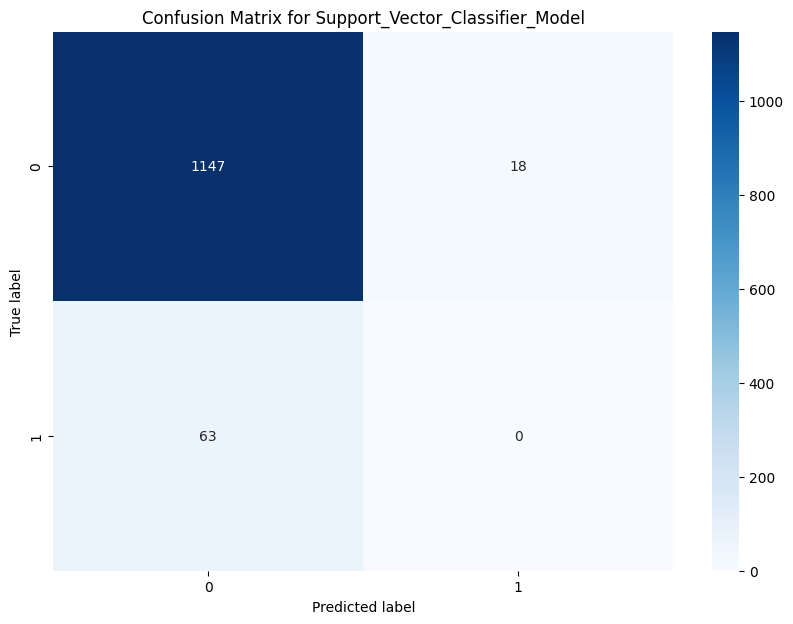

In [25]:
modelName = 'Support_Vector_Classifier_Model'
cm(y_test, y_predict, modelName)

#### ROC

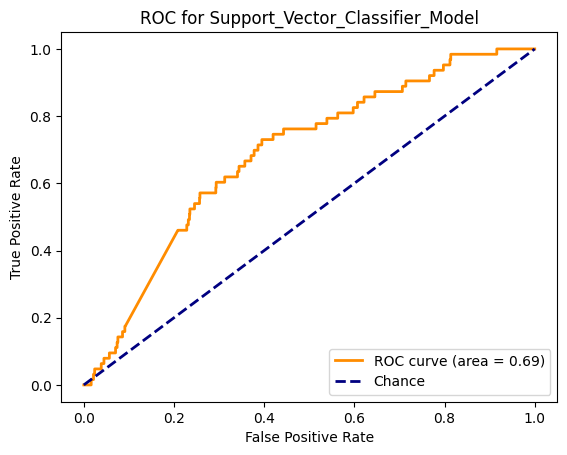

In [26]:
y_pred_prob = svc.predict_proba(X_test)[:, 1]
roc(y_test, y_pred_prob, modelName)

#### PCA and Visualization

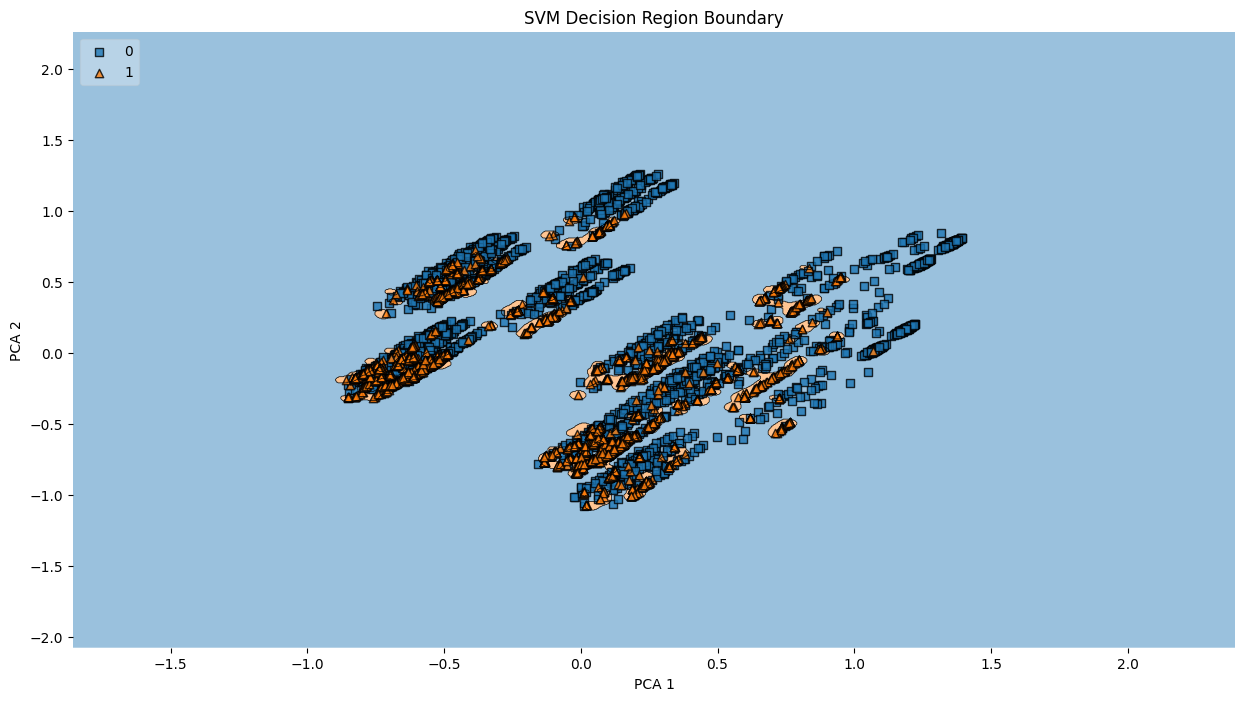

In [27]:
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
svc.fit(X_pca, y_train)
# plot
plt.figure(figsize=(15, 8))
plot_decision_regions(X_pca, y_train.to_numpy(), clf=svc, legend=2)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('SVM Decision Region Boundary')
plt.savefig(f'{modelName}_pca.png')
plt.show()

In [ ]:
我没有看见明确的决策边界，这可能是由几个因素造成的，数据质量和特征工程

In [ ]:
接下来的任务
Data Preprocessing
1. 平衡样本， 过采样多数类别
under Sampling
Over Sampling
Smote
2. 